In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks')

In [4]:
import pytorch_optimizer as optim

In [5]:
import torch
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [6]:
import torchvision.datasets
from tqdm import tqdm
import pandas as pd

In [7]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [8]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [9]:
len(y_train), len(y_test)

(50000, 10000)

In [10]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [11]:
X_train /= 255.
X_test /= 255.

In [12]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

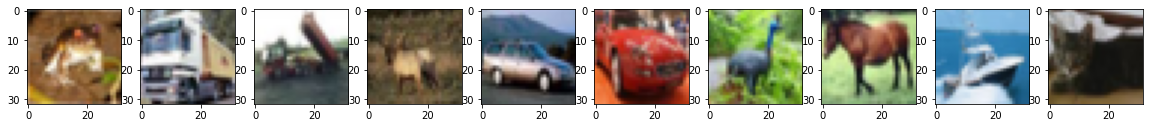

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [14]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [15]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [16]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [17]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    optimizer = optim.PNMBelief(net.parameters(), lr=1.0e-3)
    #optimizer = optim.YogiPNM(net.parameters(), lr=1.0e-3)
    
    batch_size = 500

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        print("epoch ", epoch)
        order = np.random.permutation(len(X_train))
        
        if epoch == 17:
            print("lr=1.0e-4")
            optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-4)


        for start_index in tqdm(range(0, len(X_train), batch_size)):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            #print(test_preds.argmax(dim=1))
            #print(y_test)

        print("accuracy = ", accuracy)
        print("\n\n")

    return test_accuracy_history, test_loss_history



In [18]:
accuracies = {}
losses = {}

In [19]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
accuracies['resnet18+PNMBelief'], losses['resnet18+PNMBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 100/100 [00:13<00:00,  7.47it/s]


accuracy =  0.7197999954223633



epoch  1


100%|██████████| 100/100 [00:06<00:00, 15.23it/s]


accuracy =  0.7828999757766724



epoch  2


100%|██████████| 100/100 [00:06<00:00, 15.10it/s]


accuracy =  0.7961999773979187



epoch  3


100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


accuracy =  0.7881999611854553



epoch  4


100%|██████████| 100/100 [00:06<00:00, 14.96it/s]


accuracy =  0.7978999614715576



epoch  5


100%|██████████| 100/100 [00:06<00:00, 14.88it/s]


accuracy =  0.8048999905586243



epoch  6


100%|██████████| 100/100 [00:06<00:00, 14.82it/s]


accuracy =  0.8052999973297119



epoch  7


100%|██████████| 100/100 [00:06<00:00, 14.78it/s]


accuracy =  0.8059999942779541



epoch  8


100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


accuracy =  0.8071999549865723



epoch  9


100%|██████████| 100/100 [00:06<00:00, 14.75it/s]


accuracy =  0.8206999897956848



epoch  10


100%|██████████| 100/100 [00:06<00:00, 14.83it/s]


accuracy =  0.8115999698638916



epoch  11


100%|██████████| 100/100 [00:06<00:00, 14.88it/s]


accuracy =  0.8133999705314636



epoch  12


100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


accuracy =  0.7797999978065491



epoch  13


100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


accuracy =  0.8144999742507935



epoch  14


100%|██████████| 100/100 [00:06<00:00, 14.95it/s]


accuracy =  0.820099949836731



epoch  15


100%|██████████| 100/100 [00:06<00:00, 14.91it/s]


accuracy =  0.8170999884605408



epoch  16


100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


accuracy =  0.8151999711990356



epoch  17
lr=1.0e-4


100%|██████████| 100/100 [00:06<00:00, 15.72it/s]


accuracy =  0.8330000042915344



epoch  18


100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


accuracy =  0.8330999612808228



epoch  19


100%|██████████| 100/100 [00:06<00:00, 15.68it/s]


accuracy =  0.8315999507904053



epoch  20


100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


accuracy =  0.8364999890327454



epoch  21


100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


accuracy =  0.8348000049591064



epoch  22


100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


accuracy =  0.8321999907493591



epoch  23


100%|██████████| 100/100 [00:06<00:00, 15.73it/s]


accuracy =  0.8296999931335449



epoch  24


100%|██████████| 100/100 [00:06<00:00, 15.76it/s]


accuracy =  0.8357999920845032



epoch  25


100%|██████████| 100/100 [00:06<00:00, 15.73it/s]


accuracy =  0.8345999717712402



epoch  26


100%|██████████| 100/100 [00:06<00:00, 15.76it/s]


accuracy =  0.8330999612808228



epoch  27


100%|██████████| 100/100 [00:06<00:00, 15.73it/s]


accuracy =  0.835099995136261



epoch  28


100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


accuracy =  0.8314999938011169



epoch  29


100%|██████████| 100/100 [00:06<00:00, 15.69it/s]


accuracy =  0.839199960231781





In [38]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [39]:
accuracies['resnet50+PNMBelief'], losses['resnet50+PNMBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


accuracy =  0.774899959564209



epoch  1


100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


accuracy =  0.8220999836921692



epoch  2


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


accuracy =  0.8432999849319458



epoch  3


100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


accuracy =  0.8351999521255493



epoch  4


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


accuracy =  0.8376999497413635



epoch  5


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


accuracy =  0.8339999914169312



epoch  6


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


accuracy =  0.8483999967575073



epoch  7


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


accuracy =  0.8436999917030334



epoch  8


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


accuracy =  0.8465999960899353



epoch  9


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


accuracy =  0.8542999625205994



epoch  10


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


accuracy =  0.8500999808311462



epoch  11


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


accuracy =  0.8553999662399292



epoch  12


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


accuracy =  0.8586999773979187



epoch  13


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


accuracy =  0.8560999631881714



epoch  14


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


accuracy =  0.8646000027656555



epoch  15


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


accuracy =  0.8611999750137329



epoch  16


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


accuracy =  0.8598999977111816



epoch  17
lr=1.0e-4


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


accuracy =  0.8679999709129333



epoch  18


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


accuracy =  0.8671999573707581



epoch  19


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


accuracy =  0.8694999814033508



epoch  20


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


accuracy =  0.8682000041007996



epoch  21


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


accuracy =  0.8673999905586243



epoch  22


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


accuracy =  0.8689999580383301



epoch  23


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


accuracy =  0.8708999752998352



epoch  24


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


accuracy =  0.8648999929428101



epoch  25


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


accuracy =  0.8696999549865723



epoch  26


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


accuracy =  0.8660999536514282



epoch  27


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


accuracy =  0.8655999898910522



epoch  28


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


accuracy =  0.8626999855041504



epoch  29


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


accuracy =  0.8652999997138977





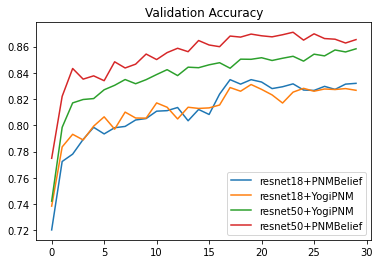

In [40]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

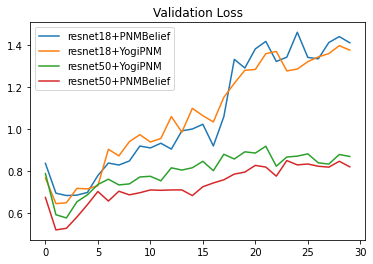

In [41]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

In [21]:
data = np.zeros((10,10), dtype=int)
D = pd.DataFrame(data)

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
test_preds = model.forward(X_test)

In [23]:
for x, y in zip(test_preds.argmax(dim=1).tolist(), y_test.tolist()):
    D[y][x] += 1

In [24]:
D # resnet18+PNMBelief

,0,1,2,3,4,5,6,7,8,9
0,879,12,42,15,14,12,8,11,34,19
1,12,906,5,8,2,1,4,2,16,43
2,24,6,793,55,35,39,27,11,7,4
3,14,3,23,635,35,103,19,21,8,6
4,9,0,47,53,838,30,34,28,1,2
5,1,2,28,151,20,753,12,29,2,2
6,3,5,33,39,12,15,888,3,3,3
7,14,3,20,26,30,34,3,882,1,7
8,29,10,5,9,11,4,3,4,917,13
9,15,53,4,9,3,9,2,9,11,901


In [ ]:
D # resnet18

,0,1,2,3,4,5,6,7,8,9
0,878,16,36,22,4,8,8,5,33,15
1,10,905,1,6,1,2,3,3,11,45
2,20,0,817,43,37,32,27,16,11,8
3,9,5,32,693,45,138,49,32,7,8
4,9,1,40,44,822,27,28,18,1,3
5,9,5,33,124,32,746,11,48,3,1
6,4,4,22,27,21,10,867,4,3,3
7,7,1,14,26,30,30,2,861,1,6
8,36,18,3,7,6,3,3,4,916,28
9,18,45,2,8,2,4,2,9,14,883
